1. Data Exploration

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import skew, norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import warnings
warnings.filterwarnings('ignore')

# test the availability of GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [39]:
df = pd.read_excel('沪深300.xlsx', header=3)
df = df.dropna(axis = 1, how = 'all')

bool_cols = []
for column in df.columns:
    if df[column].dtype == 'bool':
        bool_cols.append(column)

df.drop(['tech_MA5', 'tech_MA20'], axis=1, inplace=True)

for column in df.columns:
    if df[column].isnull().any() and column not in bool_cols:
        df[column].fillna(df[column].mean(), inplace=True)
df['highest'] = df['high'].rolling(window=10, min_periods=1).max().shift(-9)
df.dropna(subset=['highest'], inplace=True)
df['l_highest'] = np.log(df['highest'])
df

,Date,open,high,low,close,volume,amt,dealnum,adjfactor,turn,...,stage_low,up_days,down_days,breakout_ma,breakdown_ma,history_high_days,history_low_days,bull_bear_ma,highest,l_highest
0,2012-05-28,2.551,2.607,2.544,2.604,1.277519e+09,3.285755e+09,16500,1.000000,11.913721,...,True,0.96829,0.913837,False,False,1,1,False,2.661,0.978702
1,2012-05-29,2.602,2.661,2.602,2.644,7.149490e+08,1.875593e+09,11432,1.000000,6.936538,...,True,1.00000,0.000000,False,False,2,1,False,2.661,0.978702
2,2012-05-30,2.642,2.647,2.633,2.636,2.658872e+08,7.017258e+08,5532,1.000000,2.595794,...,True,0.00000,1.000000,False,False,2,1,False,2.660,0.978326
3,2012-05-31,2.621,2.645,2.613,2.630,1.781560e+08,4.681931e+08,4662,1.000000,1.747313,...,False,0.00000,2.000000,False,False,1,0,False,2.660,0.978326
4,2012-06-01,2.629,2.660,2.620,2.630,1.793500e+08,4.734772e+08,5189,1.000000,1.766249,...,False,0.00000,0.000000,False,False,0,0,False,2.660,0.978326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,2025-03-14,4.012,4.113,4.010,4.106,1.903718e+09,7.767223e+09,183727,1.207793,2.223469,...,False,1.00000,0.000000,False,False,0,0,False,4.123,1.416581
3110,2025-03-17,4.118,4.123,4.088,4.094,1.133042e+09,4.647468e+09,70612,1.207793,1.322640,...,False,0.00000,1.000000,False,False,0,0,True,4.123,1.416581
3111,2025-03-18,4.108,4.115,4.091,4.103,8.114043e+08,3.329372e+09,54696,1.207793,0.948277,...,False,1.00000,0.000000,False,False,0,0,True,4.121,1.416096
3112,2025-03-19,4.098,4.121,4.084,4.109,8.798313e+08,3.609853e+09,56596,1.207793,1.029275,...,False,2.00000,0.000000,False,False,0,0,True,4.121,1.416096


In [40]:
# check if there is any missing value
for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"There are missing values in column {col}")

In [41]:
df.columns

Index(['Date', 'open', 'high', 'low', 'close', 'volume', 'amt', 'dealnum',
       'adjfactor', 'turn', 'ADTM', 'ATR', 'BBI', 'BBIBOLL', 'BIAS', 'BOLL',
       'CCI', 'CDP', 'DMA', 'DMI', 'DMI_2', 'DPO', 'ENV', 'EXPMA', 'KDJ',
       'slowKD', 'MA', 'MACD', 'MIKE', 'MTM', 'PRICEOSC', 'PVT', 'RC', 'ROC',
       'RSI', 'SAR', 'SI', 'WR', 'OBV', 'SOBV', 'SRMI', 'PWMI', 'PRDStrong',
       'PRDWeak', 'BOTTOM', 'STD', 'TRIX', 'VHF', 'VMA', 'VMACD', 'VOSC',
       'VSTD', 'WVAD', 'vol_ratio', 'history_high', 'history_high_vol',
       'history_high_amount', 'history_low', 'stage_high', 'stage_low',
       'up_days', 'down_days', 'breakout_ma', 'breakdown_ma',
       'history_high_days', 'history_low_days', 'bull_bear_ma', 'highest',
       'l_highest'],
      dtype='object')

1.1. explore the distribution of y label

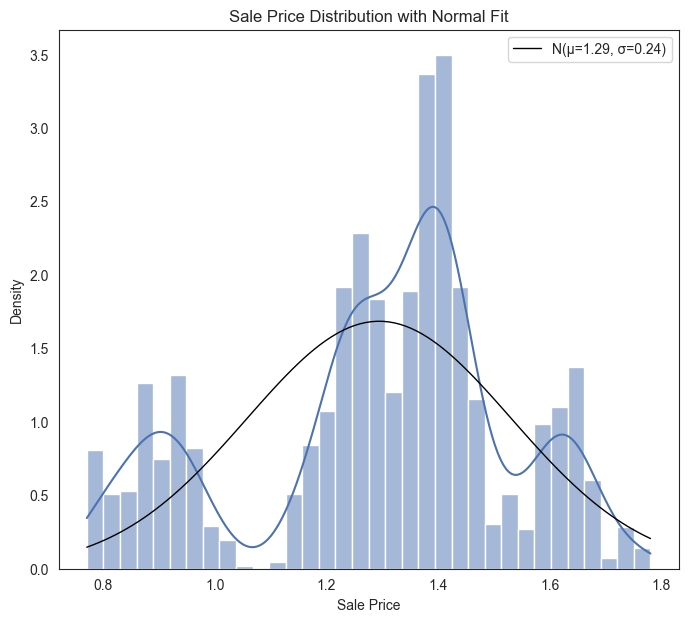

Skew: -0.509054
Kurtosis -0.392244


In [42]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
fig, ax = plt.subplots(figsize = (8,7))

sns.histplot(df['l_highest'], color='b', kde=True, stat='density', linewidth=1, ax = ax)

mu, sigma = norm.fit(df['l_highest'])
xmin, xmax = df['l_highest'].min(), df['l_highest'].max()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, color='black', linewidth=1, label=f'N(μ={mu:.2f}, σ={sigma:.2f})')
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Sale Price Distribution with Normal Fit')
plt.legend()
plt.show()

print("Skew: %f" % df['l_highest'].skew())
print("Kurtosis %f" % df['l_highest'].kurt())

1.2. explore the stationarity of the time series data

In [43]:
def test_stationarity(series):
    if series.nunique()==1:
        return 0
    adf_result = adfuller(series)
    return adf_result[1]
print('The p value for ADF test is: ', test_stationarity(df['l_highest']))

The p value for ADF test is:  0.20015235617388394


3. Model

In [ ]:
# set the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
  
# parameters
WINDOW_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 100
PATIENCE = 10
TARGET_COLUMN = 'l_highest'
FEATURES = [col for col in df.columns if col not in ['Date', 'highest', 'l_highest']]
# FEATURES = ['high']
TEST_SIZE = 0.2
BOOL_FEATURES = [col for col in FEATURES if df[col].dtype == 'bool']
NUM_FEATURES = [col for col in FEATURES if col not in BOOL_FEATURES]

In [45]:
# Dataset class
class TransformerDataset(Dataset):
    def __init__(self, dataframe, window_size, target_col, features):
        self.df = dataframe.copy()
        self.window_size = window_size
        self.target_col = target_col
        self.features = features

        # Convert boolean features to int
        self.df[BOOL_FEATURES] = self.df[BOOL_FEATURES].astype(int)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        X = self.df.iloc[idx:idx + self.window_size][self.features].values
        y = self.df.iloc[idx + self.window_size][self.target_col]
        return torch.FloatTensor(X), torch.FloatTensor([y])

In [46]:
# Transformer model for time series prediction
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, 
                                                   dim_feedforward=hidden_dim*4, 
                                                   dropout=dropout, 
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.output_linear = nn.Linear(hidden_dim, output_dim)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.input_linear.weight.data.uniform_(-initrange, initrange)
        self.output_linear.bias.data.zero_()
        self.output_linear.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, src, src_mask=None):
        # src shape: [batch_size, seq_len, input_dim]
        src = self.input_linear(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = output[:, -1, :]
        output = self.output_linear(output)
        return output

In [47]:
def train_transformer(model, train_loader, val_loader, optimizer, criterion, n_epochs, patience):
    best_model = None
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    patience_counter = 0

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses, best_val_loss

In [48]:
# Evaluation
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = model(X_batch)
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

# Evaluation metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

In [49]:
def baseline_model(test_data, window_size):
    y_pred = []
    y_true = test_data['highest'].values[window_size:] 
    
    for i in range(window_size, len(test_data)):
        max_price = test_data['high'].values[i - window_size:i].max()
        y_pred.append(max_price)
    
    y_pred = np.array(y_pred) 
    
    return y_pred, y_true

def exp_smoothing_baseline(test_data, window_size, alpha=0.1):
    high_values = test_data['high'].values 
    highest_values = test_data['highest'].values 
    predictions = [] 

    for i in range(len(high_values)):
        if i < window_size:
            predictions.append(np.mean(high_values[:i+1]))
        else:
            ema = 0  
            weights = np.array([alpha * (1 - alpha) ** j for j in range(window_size)])
            weights /= weights.sum() 
            history = high_values[i-window_size+1:i+1]
            ema = np.sum(weights * history)
            predictions.append(ema)

    y_pred = np.array(predictions)
    y_true = highest_values

    return y_pred, y_true

def moving_average_baseline(test_data, window_size):
    ma_values = test_data['high'].rolling(window=window_size).mean().values
    y_pred = ma_values[window_size-1:-1] 
    y_true = test_data['highest'].values[window_size:]
    
    return y_pred, y_true

In [50]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(y_true, y_pred_transformer, model_name="Transformer"):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred_transformer, label=f'{model_name} Predictions', color='red')
    plt.title(f'Stock Price Prediction: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('High Price')
    plt.legend()
    # plt.xlim(0, 200)
    plt.grid(True)
    plt.show()

def plot_scatter_comparison(transformer_actuals, transformer_preds):
    plt.figure(figsize=(12, 6))
    
    plt.scatter(transformer_actuals, transformer_preds, alpha=0.5)
    plt.plot([min(transformer_actuals), max(transformer_actuals)], 
             [min(transformer_actuals), max(transformer_actuals)], 'r')
    plt.title('Transformer: Actual vs Predicted')
    plt.xlabel('Actual High Price')
    plt.ylabel('Predicted High Price')
    plt.show()

In [51]:
# Main function
def main_transformer():
    # Split data into train and test sets
    train_size = int(len(df) * (1 - TEST_SIZE))
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=4)

    # the best model and its validation loss
    best_model_state = None
    best_val_loss = float('inf')
    final_train_losses = None
    final_val_losses = None
    best_fold_scaler = None

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_data)):
        print(f"Fold {fold + 1}")
        fold_train_data = train_data.iloc[train_idx]
        fold_val_data = train_data.iloc[val_idx]

        # Scale data
        scaler = StandardScaler()
        scaler.fit(fold_train_data[NUM_FEATURES])
        fold_train_data[NUM_FEATURES] = scaler.transform(fold_train_data[NUM_FEATURES])
        fold_val_data[NUM_FEATURES] = scaler.transform(fold_val_data[NUM_FEATURES])

        # Create datasets and loaders
        train_dataset = TransformerDataset(fold_train_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
        val_dataset = TransformerDataset(fold_val_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # Model
        # parameters for the model
        input_dim = len(FEATURES) 
        hidden_dim = 32            
        num_layers = 4             
        output_dim = 1
        drop_out = 0.1  
        lr = 0.001  
        
        # initialize the model
        model = TimeSeriesTransformer(input_dim, hidden_dim, num_layers, output_dim, drop_out).to(DEVICE)
        # optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        # model training
        transformer_model, train_losses, val_losses,fold_best_val_loss = train_transformer(model, train_loader, val_loader, optimizer, criterion, EPOCHS, PATIENCE)
        print(f"Fold {fold+1} The best validation loss is: {fold_best_val_loss:.4f}")

        # save the best model
        if fold_best_val_loss < best_val_loss:
            best_val_loss = fold_best_val_loss
            best_model_state = transformer_model.state_dict().copy()
            final_train_losses = train_losses
            final_val_losses = val_losses
            best_fold_scaler = scaler
            print(f"The best model is saved in Fold {fold+1}")

    final_model = TimeSeriesTransformer(input_dim, hidden_dim, num_layers, output_dim, drop_out).to(DEVICE)
    final_model.load_state_dict(best_model_state)

    # plot the loss curves
    plot_loss(final_train_losses, final_val_losses)

    # evaluation in the test set
    print("\nevaluating the model on the test set...")
    # evaluate the baseline model on the test set
    baseline_preds1, baseline_actuals1 = baseline_model(test_data, 50)
    baseline_preds2, baseline_actuals2 = moving_average_baseline(test_data, 50)
    baseline_preds3, baseline_actuals3 = exp_smoothing_baseline(test_data, 50)

    # evaluate the transformer model on the test set
    test_data[NUM_FEATURES] = best_fold_scaler.transform(test_data[NUM_FEATURES])
    test_dataset = TransformerDataset(test_data, WINDOW_SIZE, TARGET_COLUMN, FEATURES)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    transformer_actuals, transformer_preds= evaluate_transformer_model(final_model, test_loader)

    # invert the log transformation
    transformer_actuals = np.exp(transformer_actuals)
    transformer_preds = np.exp(transformer_preds)

    #make sure models have the same length of predictions and actuals
    min_len = min(len(transformer_actuals), len(baseline_actuals1), len(baseline_actuals2), len(baseline_actuals3))
    transformer_preds = transformer_preds[:min_len]
    transformer_actuals = transformer_actuals[:min_len]
    baseline_preds1 = baseline_preds1[:min_len]
    baseline_actuals1 = baseline_actuals1[:min_len]
    baseline_preds2 = baseline_preds2[:min_len]
    baseline_actuals2 = baseline_actuals2[:min_len]
    baseline_preds3 = baseline_preds3[:min_len]
    baseline_actuals3 = baseline_actuals3[:min_len]

    # calculate the metrics for the transformer and baseline models
    transformer_metrics = calculate_metrics(transformer_actuals, transformer_preds)
    baseline_metrics1 = calculate_metrics(baseline_actuals1, baseline_preds1)
    baseline_metrics2 = calculate_metrics(baseline_actuals2, baseline_preds2)
    baseline_metrics3 = calculate_metrics(baseline_actuals3, baseline_preds3)

    print("\nTransformer's performance:")
    for metric, value in transformer_metrics.items():
        print(f"{metric}: {value:.6f}")
    
    print("\nBaseline's performance:")
    for metric, value in baseline_metrics1.items():
        print(f"{metric}: {value:.6f}")
   
    print("\nMoving Average Baseline's performance:")
    for metric, value in baseline_metrics2.items():
        print(f"{metric}: {value:.6f}")
    
    print("\nExponential Smoothing Baseline's performance:")
    for metric, value in baseline_metrics3.items():
        print(f"{metric}: {value:.6f}")
    
    # visualize the predictions
    plot_predictions(transformer_actuals, transformer_preds)
    plot_predictions(baseline_actuals1, baseline_preds1, 'baseline: highest price over the past 50 days')
    plot_predictions(baseline_actuals2, baseline_preds2, 'baseline: moving average')
    plot_predictions(baseline_actuals3, baseline_preds3, 'baseline: exponential smoothing')

    # calculate the improvement of the transformer over the baseline model
    improvement_rmse1 = (baseline_metrics1['RMSE'] - transformer_metrics['RMSE']) / baseline_metrics1['RMSE'] * 100
    improvement_mae1 = (baseline_metrics1['MAE'] - transformer_metrics['MAE']) / baseline_metrics1['MAE'] * 100

    improvement_rmse2 = (baseline_metrics2['RMSE'] - transformer_metrics['RMSE']) / baseline_metrics2['RMSE'] * 100
    improvement_mae2 = (baseline_metrics2['MAE'] - transformer_metrics['MAE']) / baseline_metrics2['MAE'] * 100

    improvement_rmse3 = (baseline_metrics3['RMSE'] - transformer_metrics['RMSE']) / baseline_metrics3['RMSE'] * 100
    improvement_mae3 = (baseline_metrics3['MAE'] - transformer_metrics['MAE']) / baseline_metrics3['MAE'] * 100

    print(f"\nTransformer's improvement over the baseline model in terms of ':")
    print(f"RMSE: {improvement_rmse1:.4f}%")
    print(f"MAE: {improvement_mae1:.4f}%")

    print(f"\nTransformer's improvement over the baseline model Moving Average in terms of ':")
    print(f"RMSE: {improvement_rmse2:.4f}%")
    print(f"MAE: {improvement_mae2:.4f}%")

    print(f"\nTransformer's improvement over the baseline model Exponential Smoothing in terms of ':")
    print(f"RMSE: {improvement_rmse3:.4f}%")
    print(f"MAE: {improvement_mae3:.4f}%")

    # visualize the comparison of the actuals and predictions
    plot_scatter_comparison(transformer_actuals, transformer_preds)

    return {
        'model': final_model,
        'transformer_metrics': transformer_metrics,
        'transformer_preds': transformer_preds,
        'transformer_actuals': transformer_actuals,
        'scaler': best_fold_scaler
    }


Fold 1
Epoch 1, Train Loss: 0.2487, Val Loss: 0.0435
Epoch 2, Train Loss: 0.0307, Val Loss: 0.2275
Epoch 3, Train Loss: 0.0188, Val Loss: 0.1455
Epoch 4, Train Loss: 0.0099, Val Loss: 0.1194
Epoch 5, Train Loss: 0.0041, Val Loss: 0.1411
Epoch 6, Train Loss: 0.0039, Val Loss: 0.1016
Epoch 7, Train Loss: 0.0025, Val Loss: 0.0981
Epoch 8, Train Loss: 0.0024, Val Loss: 0.1110
Epoch 9, Train Loss: 0.0021, Val Loss: 0.1042
Epoch 10, Train Loss: 0.0022, Val Loss: 0.1042
Epoch 11, Train Loss: 0.0020, Val Loss: 0.0981
Early stopping triggered.
Fold 1 The best validation loss is: 0.0435
The best model is saved in Fold 1
Fold 2
Epoch 1, Train Loss: 0.1309, Val Loss: 0.0745
Epoch 2, Train Loss: 0.0242, Val Loss: 0.0038
Epoch 3, Train Loss: 0.0087, Val Loss: 0.0022
Epoch 4, Train Loss: 0.0062, Val Loss: 0.0038
Epoch 5, Train Loss: 0.0049, Val Loss: 0.0021
Epoch 6, Train Loss: 0.0048, Val Loss: 0.0047
Epoch 7, Train Loss: 0.0043, Val Loss: 0.0069
Epoch 8, Train Loss: 0.0040, Val Loss: 0.0071
Epoch 9

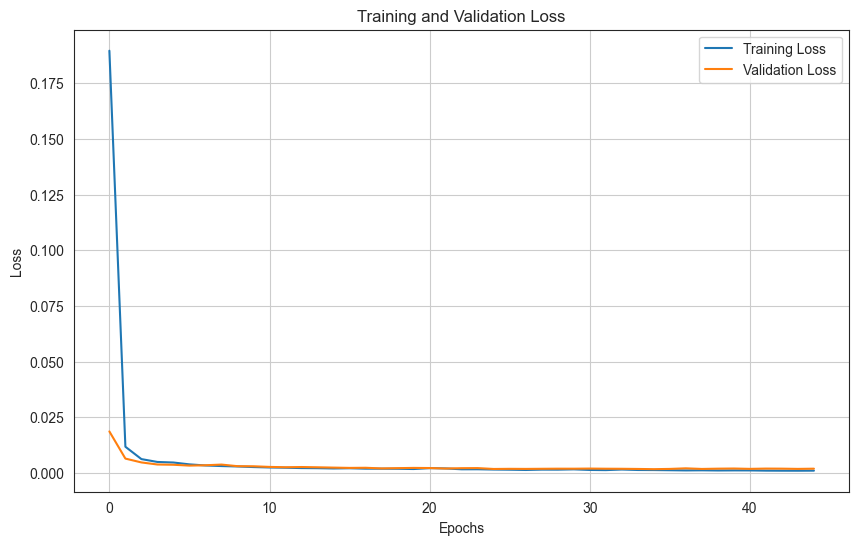


evaluating the model on the test set...

Transformer's performance:
MSE: 0.056582
RMSE: 0.237869
MAE: 0.167842
R2: 0.296087

Baseline's performance:
MSE: 0.070102
RMSE: 0.264769
MAE: 0.201483
R2: 0.154145

Moving Average Baseline's performance:
MSE: 0.059945
RMSE: 0.244837
MAE: 0.149814
R2: 0.276702

Exponential Smoothing Baseline's performance:
MSE: 0.085598
RMSE: 0.292571
MAE: 0.194614
R2: -0.027476


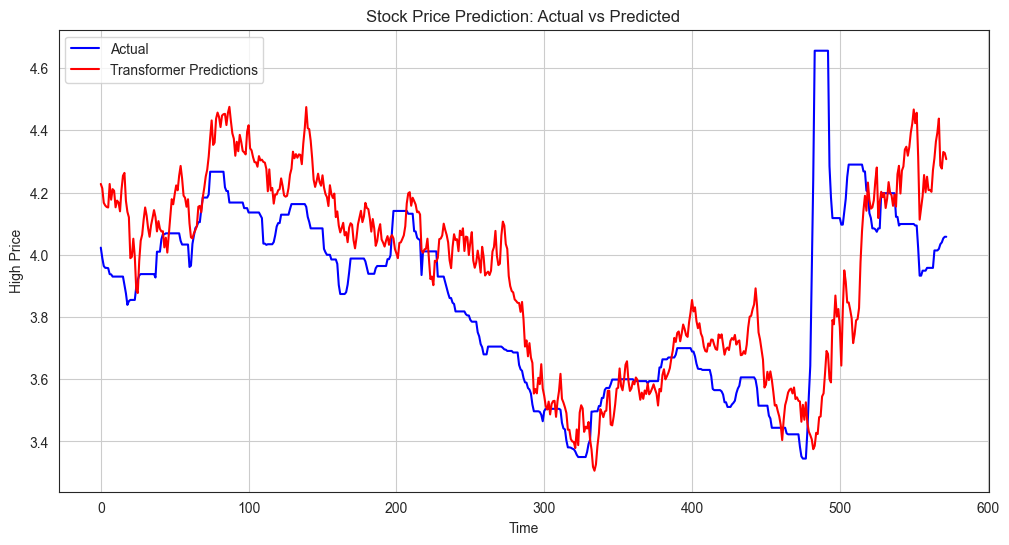

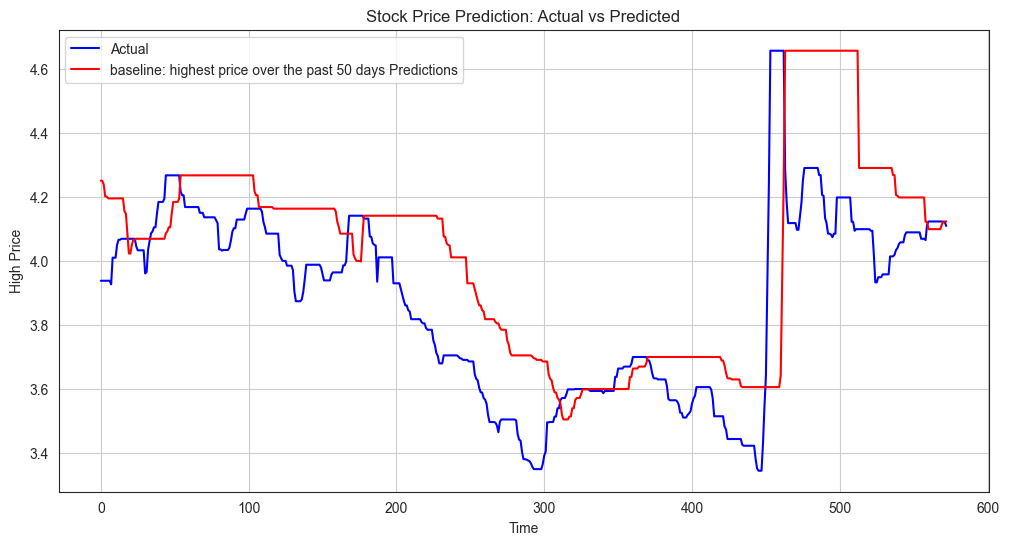

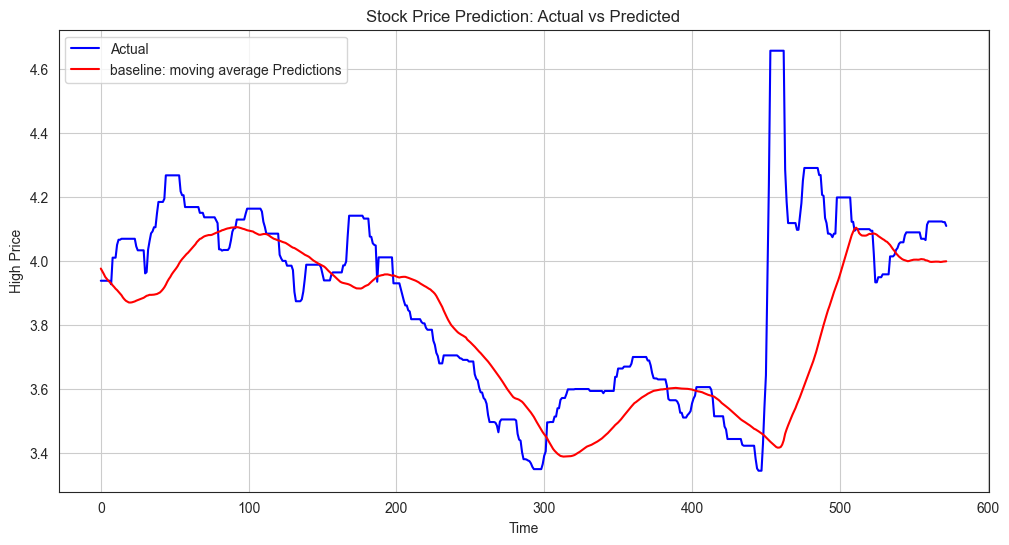

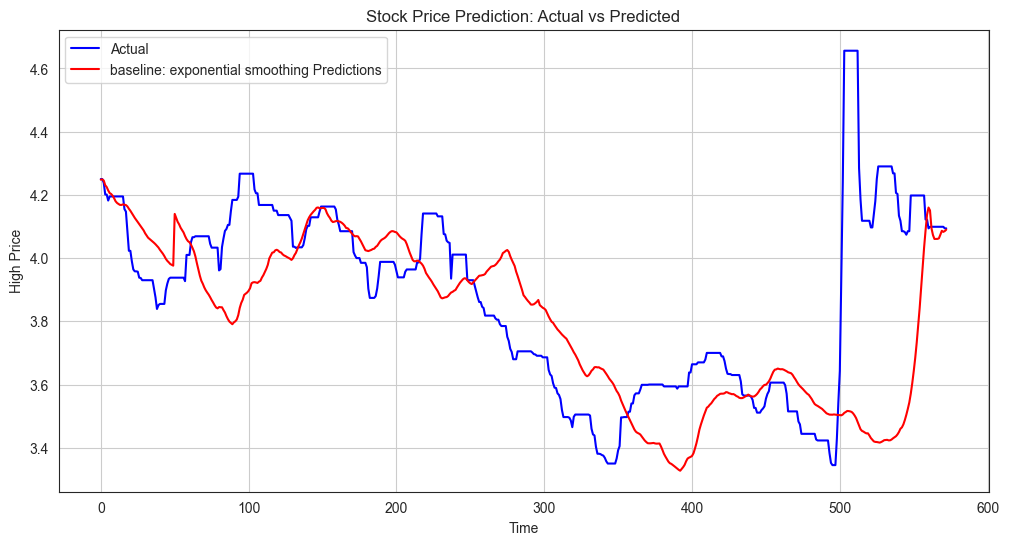


Transformer's improvement over the baseline model in terms of ':
RMSE: 10.1598%
MAE: 16.6967%

Transformer's improvement over the baseline model Moving Average in terms of ':
RMSE: 2.8462%
MAE: -12.0340%

Transformer's improvement over the baseline model Exponential Smoothing in terms of ':
RMSE: 18.6971%
MAE: 13.7562%


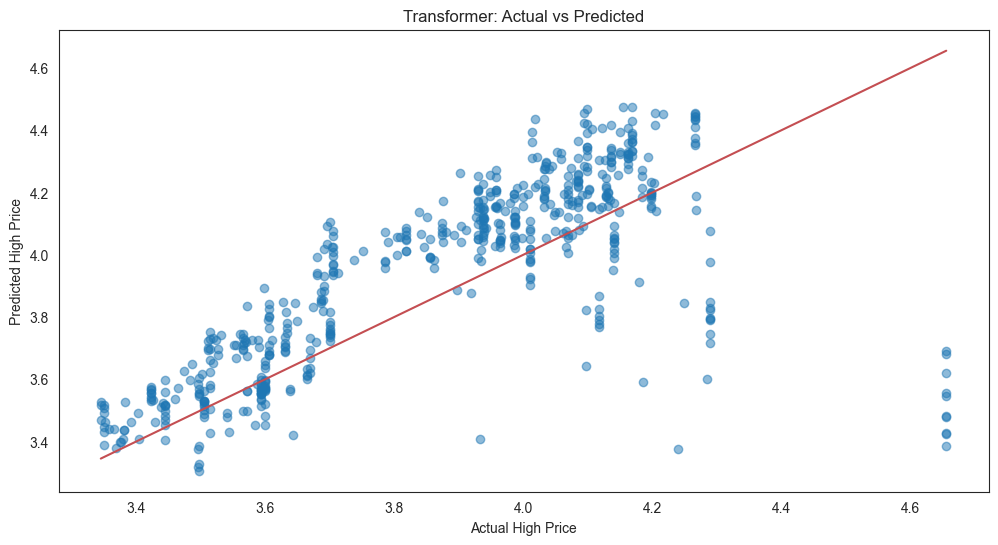

In [52]:
main_transformer()
print()